In [1]:
# !pip -q install statsmodels
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from itertools import product
from typing import Tuple, Dict

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
print("Python:", sys.version.split()[0])


Python: 3.11.13


In [2]:
DATA_PATH = "/kaggle/input/eascaq/co2_country_clean.csv"  # dari EDA kamu
assert os.path.exists(DATA_PATH), "File tidak ditemukan, pastikan jalur benar."

df = pd.read_csv(DATA_PATH)

# country-only (jika ada kolom description)
if "description" in df.columns:
    df = df[df["description"].str.lower() == "country"].copy()

# year ke integer
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

COUNTRY = "Indonesia"   # sesuaikan
metric  = "co2"         # HANYA co2 (excl. LUC)

# 1) REKONSTRUKSI co2 jika hilang:
#    co2 ≈ coal + oil + gas + cement + flaring  (excl. LUC)
sector_cols = [c for c in ["coal_co2","oil_co2","gas_co2","cement_co2","flaring_co2"] if c in df.columns]
if sector_cols:
    df["_co2_from_sectors"] = df[sector_cols].sum(axis=1, skipna=True)
else:
    df["_co2_from_sectors"] = np.nan

# 2) Alternatif jika masih NaN: co2_proxy = co2_including_luc - land_use_change_co2
if {"co2_including_luc","land_use_change_co2"}.issubset(df.columns):
    df["_co2_proxy"] = df["co2_including_luc"] - df["land_use_change_co2"]
else:
    df["_co2_proxy"] = np.nan

# 3) Isi co2 yang hilang: prioritaskan sektor → proxy → tetap NaN kalau tidak ada
if "co2" not in df.columns:
    df["co2"] = np.nan
df["co2"] = df["co2"].where(df["co2"].notna(), df["_co2_from_sectors"])
df["co2"] = df["co2"].where(df["co2"].notna(), df["_co2_proxy"])

# (Opsional) batasi ke era modern agar model lebih stabil
MIN_YEAR = 1960
df = df[df["year"].ge(MIN_YEAR)]

# Ambil seri negara
d = (df[df["name"] == COUNTRY][["year", "co2"]]
       .dropna(subset=["year","co2"])
       .sort_values("year"))

# === Penting: jangan pakai .asfreq('Y') agar tidak menyisipkan tahun kosong ===
ts = d.set_index(pd.to_datetime(d["year"].astype(int), format="%Y"))["co2"]
ts.name = f"{COUNTRY} — CO₂ (MtCO₂)"

display(ts.tail())  # harusnya sudah tidak NaN di ekor

# Train-test split (10 tahun terakhir untuk uji)
TEST_YEARS = min(20, len(ts)-1)  # jaga-jaga kalau data pendek
train = ts.iloc[:-TEST_YEARS] if TEST_YEARS > 0 else ts
test  = ts.iloc[-TEST_YEARS:]  if TEST_YEARS > 0 else ts.iloc[[]]

print("Train span:", train.index.min().year, "→", train.index.max().year,
      "| Test span:", (test.index.min().year if len(test) else None), "→", (test.index.max().year if len(test) else None))


year
2019-01-01   653.7920
2020-01-01   608.2230
2021-01-01   619.6220
2022-01-01   737.0730
2023-01-01   733.2240
Name: Indonesia — CO₂ (MtCO₂), dtype: float64

Train span: 1960 → 2003 | Test span: 2004 → 2023


In [3]:
def fourier_terms(index: pd.DatetimeIndex, period:int, K:int) -> pd.DataFrame:
    """
    Buat Fourier terms (sin/cos) untuk perioda 'period' (tahun) dengan K harmonik.
    Cocok untuk data tahunan agar forecast "naik-turun"/bergelombang.
    """
    t = np.arange(len(index))
    cols = {}
    for k in range(1, K+1):
        cols[f"sin_{period}_{k}"] = np.sin(2*np.pi*k*t/period)
        cols[f"cos_{period}_{k}"] = np.cos(2*np.pi*k*t/period)
    return pd.DataFrame(cols, index=index)


In [4]:
period_candidates = [4, 6, 8, 10]
K_candidates = [1, 2, 3]
pdq_candidates = [(p,d,q) for p,d,q in product([0,1,2], [0,1], [0,1,2])]  # kecil, cukup
best = None
records = []

def fit_eval(train, test, period, K, pdq) -> Tuple[float, Dict]:
    # exog train/test
    X_tr = fourier_terms(train.index, period, K)
    X_te = fourier_terms(test.index,  period, K)

    # Model SARIMAX dengan exog Fourier (tanpa komponen musiman "S" karena data tahunan)
    try:
        model = SARIMAX(train, order=pdq, exog=X_tr, enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        # Forecast horizon = len(test)
        fc = res.get_forecast(steps=len(test), exog=X_te)
        yhat = fc.predicted_mean
        mae = np.mean(np.abs(test - yhat))
        # simpan
        out = {
            "period": period, "K": K, "p": pdq[0], "d": pdq[1], "q": pdq[2],
            "mae": mae, "aic": res.aic
        }
        return mae, out
    except Exception as e:
        return np.inf, {"period": period, "K": K, "p": pdq[0], "d": pdq[1], "q": pdq[2], "mae": np.inf, "aic": np.inf}

for P in period_candidates:
    for K in K_candidates:
        for pdq in pdq_candidates:
            mae, info = fit_eval(train, test, P, K, pdq)
            records.append(info)
            if (best is None) or (mae < best["mae"]):
                best = info

grid = pd.DataFrame(records).sort_values(["mae","aic"])
display(grid.head(10))
print("Best config:", best)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

,period,K,p,d,q,mae,aic
107,6,3,2,1,2,24.0619,327.6888
100,6,3,1,1,1,25.5168,335.2185
106,6,3,2,1,1,26.2268,333.6816
89,6,2,2,1,2,27.2877,324.1645
101,6,3,1,1,2,28.2232,327.3413
25,4,2,1,0,1,33.0351,445.0389
53,4,3,2,1,2,33.7761,325.2956
32,4,2,2,0,2,35.4022,433.1936
88,6,2,2,1,1,40.0875,330.5986
26,4,2,1,0,2,41.0766,437.6444


Best config: {'period': 6, 'K': 3, 'p': 2, 'd': 1, 'q': 2, 'mae': 24.061931143902846, 'aic': 327.6888354638908}


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_37/489405303.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  full_index   = pd.date_range(start=start_idx, end=end_idx, freq="Y")


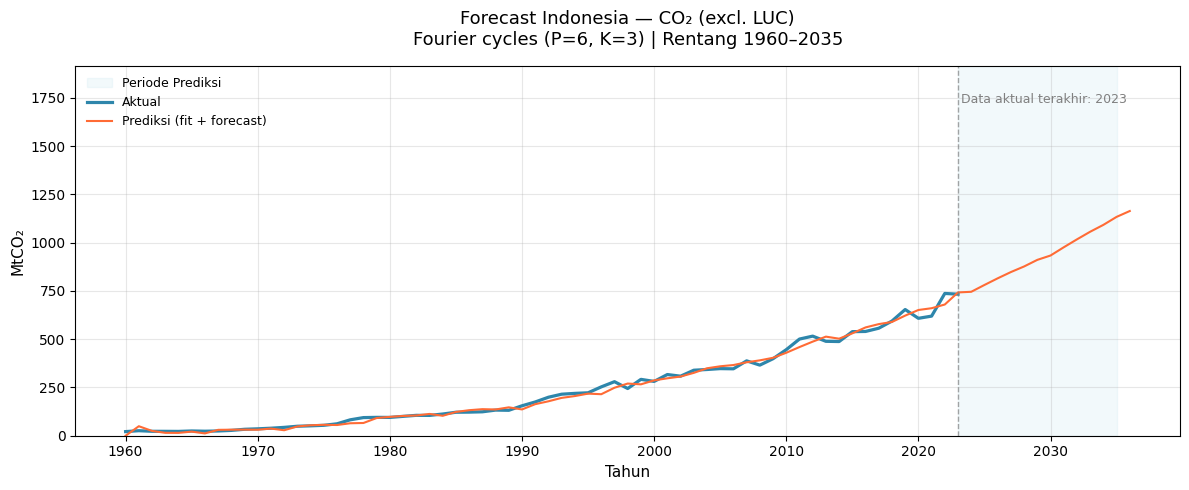

Gambar berhasil disimpan sebagai: forecast_indonesia_co2_2035.png
📈 Prediksi emisi Indonesia hingga 2035: 1,164.1 MtCO₂
📊 Rata-rata emisi Indonesia selama 2024–2035: 950.1 MtCO₂/tahun
↗️ Perubahan vs 2023: 58.8%


In [5]:
# Fit ulang pada SELURUH data (train+test) agar parameter lebih stabil
P_best, K_best, pdq_best = int(best["period"]), int(best["K"]), (int(best["p"]), int(best["d"]), int(best["q"]))

X_all = fourier_terms(ts.index, P_best, K_best)
final_model = SARIMAX(ts, order=pdq_best, exog=X_all, enforce_stationarity=False, enforce_invertibility=False)
final_res = final_model.fit(disp=False)

# ==== Forecast kontinu dari awal data s.d. 2035 ====
TARGET_YEAR = 2035
last_year = ts.index[-1].year
start_idx = ts.index[0]
end_idx = pd.Timestamp(year=TARGET_YEAR, month=12, day=31)  # YE-DEC

# 1) Index penuh & index masa depan
full_index   = pd.date_range(start=start_idx, end=end_idx, freq="Y")
future_index = full_index[full_index > ts.index[-1]]

# 2) Prediksi in-sample (TANPA exog tambahan)
pred_in = final_res.get_prediction(start=0, end=len(ts)-1)  # in-sample only
yhat_in = pred_in.predicted_mean
ci_in   = pred_in.conf_int(alpha=0.2)

# === Gabungkan hasil in-sample dan forecast menjadi satu deret ===
# (1) bagian sebelumnya tetap
if len(future_index) > 0:
    X_future = fourier_terms(future_index, P_best, K_best)
    fc_out   = final_res.get_forecast(steps=len(future_index), exog=X_future)
    yhat_out = fc_out.predicted_mean
    ci_out   = fc_out.conf_int(alpha=0.2)
else:
    yhat_out = pd.Series(dtype=float)
    ci_out   = pd.DataFrame(columns=["lower", "upper"])

# ==== GABUNGKAN IN-SAMPLE + OUT-OF-SAMPLE ====
# Standardisasi kolom CI jika kamu masih ingin menyimpannya (opsional, tidak dipakai di plot)
def _std_ci(ci_df):
    if ci_df is None or len(ci_df) == 0:
        return pd.DataFrame(columns=["lower","upper"])
    ci_df = ci_df.copy()
    ci_df.columns = ["lower","upper"]
    return ci_df

ci_in_std  = _std_ci(ci_in)
ci_out_std = _std_ci(ci_out)

# Prediksi penuh (fit + forecast)
yhat_full = pd.concat([yhat_in, yhat_out]).sort_index()
ci_full   = pd.concat([ci_in_std, ci_out_std]) if (len(ci_in_std) or len(ci_out_std)) else pd.DataFrame()

# --- Pastikan non-negatif untuk visual yang wajar ---
yhat_full = yhat_full.clip(lower=0)

# Skala sumbu-Y: mulai 0, beri margin
ymax_candidates = []
if len(ts):          ymax_candidates.append(float(np.nanmax(ts.values)))
if len(yhat_full):   ymax_candidates.append(float(np.nanmax(yhat_full.values)))
if ci_full.size:     ymax_candidates.append(float(np.nanmax(ci_full.get("upper", pd.Series([np.nan])).values)))
ymax = (max(ymax_candidates) if ymax_candidates else 1.0) * 1.05

# ==== PLOTTING ====
plt.figure(figsize=(12,5))

# Area masa depan diwarnai
plt.axvspan(last_year, TARGET_YEAR, color="lightblue", alpha=0.15, label="Periode Prediksi")

# Garis aktual
plt.plot(ts.index.year, ts.values, color="#2E86AB", linewidth=2.3, label="Aktual")

# Garis prediksi (fit + forecast) — ini yang kamu minta “muncul” sebagai satu garis kontinu
plt.plot(yhat_full.index.year, yhat_full.values, color="#FF6B35", linewidth=1.5, linestyle="-", label="Prediksi (fit + forecast)")

# Garis batas cutoff
plt.axvline(x=last_year, color="gray", linestyle="--", linewidth=1, alpha=0.7)
plt.text(last_year+0.2, ymax*0.9, f"Data aktual terakhir: {last_year}", fontsize=9, color="gray")

# Judul & axis
plt.title(
    f"Forecast {COUNTRY} — CO₂ (excl. LUC)\nFourier cycles (P={P_best}, K={K_best}) | Rentang {ts.index[0].year}–{TARGET_YEAR}",
    fontsize=13, pad=15
)
plt.xlabel("Tahun", fontsize=11)
plt.ylabel("MtCO₂", fontsize=11)
plt.ylim(0, ymax)
plt.grid(alpha=0.3)
plt.legend(frameon=False, fontsize=9)
plt.tight_layout()

# 💾 Simpan PNG
save_path = f"forecast_{COUNTRY.lower().replace(' ','_')}_co2_{TARGET_YEAR}.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight", transparent=False)
plt.show()
print(f"Gambar berhasil disimpan sebagai: {save_path}")

# ==== OUTPUT TEKS RINGKAS ====
future_pred = yhat_full[yhat_full.index.year > last_year]
if not future_pred.empty:
    last_val    = future_pred.iloc[-1]
    mean_future = future_pred.mean()
    pct_change  = ((last_val - ts.iloc[-1]) / ts.iloc[-1] * 100.0) if ts.iloc[-1] not in [0, np.nan] else np.nan
    print(f"📈 Prediksi emisi {COUNTRY} hingga {TARGET_YEAR}: {last_val:,.1f} MtCO₂")
    print(f"📊 Rata-rata emisi {COUNTRY} selama {last_year+1}–{TARGET_YEAR}: {mean_future:,.1f} MtCO₂/tahun")
    if np.isfinite(pct_change):
        print(f"↗️ Perubahan vs {last_year}: {pct_change:,.1f}%")
else:
    print("Tidak ada data prediksi masa depan — periksa rentang tahun atau model.")


## DISIMPAN UNTUK DILAKUKAN SKENARIO SIMULATOR

In [7]:
# ======================================================
# 🔽 EXPORT HASIL FORECAST → CSV (untuk dipakai Gradio)
# Syarat: variabel: ts, yhat_full, TARGET_YEAR, COUNTRY
# ======================================================
import os
import pandas as pd
import numpy as np

outdir = "reports/forecast_exports"
os.makedirs(outdir, exist_ok=True)

# 1) Tabel prediksi (fit + forecast)
df_forecast = pd.DataFrame({
    "date": yhat_full.index,                    # DatetimeIndex YE-DEC
    "year": yhat_full.index.year.astype(int),   # Tahun
    "predicted_mtco2": yhat_full.values.astype(float),
})

# 2) Gabungkan dengan aktual (jika ada) TANPA bikin kolom duplikat
if len(ts):
    df_actual = pd.DataFrame({
        "year": ts.index.year.astype(int),
        "actual_mtco2": ts.values.astype(float),
    })
    # Merge ke df_forecast → hasilkan kolom actual_mtco2
    df_forecast = df_forecast.merge(df_actual, on="year", how="left")

# 3) Simpan full series (fit + forecast)
full_path = os.path.join(outdir, f"forecast_full_{COUNTRY.lower().replace(' ','_')}_to_{TARGET_YEAR}.csv")
df_forecast.to_csv(full_path, index=False)
print(f"✅ CSV full series tersimpan: {full_path}")

# 4) Simpan SATU baris anchor {TARGET_YEAR}: format (year,total)
row_target = df_forecast[df_forecast["year"] == int(TARGET_YEAR)].copy()
if row_target.empty:
    print(f"⚠️ Tidak menemukan baris year == {TARGET_YEAR} pada yhat_full.")
else:
    # Prioritas pakai predicted; jika NaN fallback ke actual
    row_target["total"] = row_target["predicted_mtco2"].fillna(row_target.get("actual_mtco2"))
    df_anchor = row_target[["year","total"]].head(1)
    one_path = os.path.join(outdir, f"forecast_anchor_{COUNTRY.lower().replace(' ','_')}_{TARGET_YEAR}.csv")
    df_anchor.to_csv(one_path, index=False)
    print(f"✅ CSV anchor {TARGET_YEAR} tersimpan: {one_path}")
    print(df_anchor)

# (Opsional) ringkasan anchor di log
if not row_target.empty:
    anchor_val = float(df_anchor["total"].iloc[0])
    print(f"📌 Anchor {TARGET_YEAR} untuk {COUNTRY}: {anchor_val:,.1f} MtCO₂")


✅ CSV full series tersimpan: reports/forecast_exports/forecast_full_indonesia_to_2035.csv
✅ CSV anchor 2035 tersimpan: reports/forecast_exports/forecast_anchor_indonesia_2035.csv
    year      total
75  2035 1,133.6973
📌 Anchor 2035 untuk Indonesia: 1,133.7 MtCO₂
